# Stochastic Skeleton Model Analysis

This notebook implements and analyzes the Stochastic MJO Skeleton Model with time-dependent observation-based forcing profiles.
Results have been presented in Chapter 9 of my thesis : [Complex systems perspectives on large-scale weather and climate variability patterns, Noémie Ehstand](https://www.researchgate.net/publication/382743987_Complex_systems_perspectives_on_large-scale_weather_and_climate_variability_patterns)


The notebook is organized as follows: 


**0.** Setup: first we load all necessary packages and custom functions, the simulation parameters and forcing profiles

**1.**  Compute initial conditions

**2.**  Integrate model 

**3.**  Visualize the model output

**4.**  Compute the Skeleton Multivariate MJO (SMM) index and identify MJO events

**5.**  Compute and visualize characteristics of simulated MJO events

**6.**  Modulation of MJO events characteristics by ENSO 


For reference:

--- 

*standard parameters (non dimensional)*

Hbar, Qbar, Γ, γ, Abar, Δa, Sref 

--- 
*dimensionalization constants*

Dₐ(km), Tₐ(h), Θₐ(Kelvin), Uₐ(m/s)  

--- 
*simulation specific parameters*

L, Nx, dx, Δt, T (total simulation time, dimensionless), Nt
κ (spatial frequencies)

dostocha (stochastic switch)
REPEAT (repetitions to reach equilibrium)

---
*forcing*

longitudes (longitudinal points at which forcing is defined)
Stheta, Sq, Aₛ (forcing profiles & background)

satisfying 
̄HAₛ=(Sq-̄Q*Stheta)/(1-Q) 

---



# Stochastic skeleton model for the Madden-Julian Oscillation with time-dependent observation-based forcing

This repository implements and analyzes the Stochastic MJO Skeleton Model with time-dependent observation-based forcing functions. This work corresponds to the results presented in Chapter 9 of my thesis: [Complex Systems Perspectives on Large-Scale Weather and Climate Variability Patterns, Noémie Ehstand](https://www.researchgate.net/publication/382743987_Complex_systems_perspectives_on_large-scale_weather_and_climate_variability_patterns).

## Running the notebooks

To run the notebooks in this repository, ensure you have Python and Julia installed along with the necessary packages (listed bellow). You can clone the repository using:

```bash
git clone https://github.com/yourusername/repository-name.git
cd repository-name
```


Required Julia packages: `LinearAlgebra`, `FFTW`, `PyPlot`, `Statistics`, `Interpolations`, `Random`, `Distributions`

Required python packages: `numpy`, `matplotlib`, `pandas`, `pickle`, `netCDF4`, `cftime`, `datetime`, `xarray`, `scipy`

## Data Sources
- NCEP-NCAR reanalysis latent heat net flux (Kalnay et al., 1996) is available [here](https://psl.noaa.gov/data/gridded/data.ncep.reanalysis.html)
- NCEP global precipitation climatology project data (Adler et al., 2017; Huffman et al., 2001) is available [here](https://www.ncei.noaa.gov/products/climate-data-records/precipitation-gpcp-monthly).

## Notebooks Overview

**`forcing-profiles.ipynb`**

This notebook computes the model’s forcing based on the methodology presented in [Ogrosky and Stechman (2015)](https://doi.org/10.1002/qj.2552), while retaining the time-dependence of the profiles.
 
**`Stochastic-skeleton-model-main.ipynb`**

This notebook contains the implementation of the stochastic MJO skeleton model, along with post-processing and analysis of the model's outputs.

**`Stochastic-skeleton-model-plots.ipynb`**

This notebook is designed specifically to reproduce the plots presented in my thesis. The data required for the plots is available [here](https://cloud.ifisc.uib-csic.es/nextcloud/index.php/s/9j9QBPZ4ZgkkNHD).



In [11]:
# packages and dependencies 
using LinearAlgebra
using FFTW
using PyPlot
using Statistics
using Interpolations
using Random, Distributions

In [3]:
# where are simulation and forcing data stored
data_folder = "data/";

# loading custom functions
include("functions/evolve_functions.jl");
include("functions/filters.jl");
include("functions/smm.jl");
include("functions/events_characteristics.jl");

In [4]:
# initialize simulation parameters and load forcing profiles 
include("params/params.jl");
println("Simulation period: ", d1_y, " - ", d2_y);

Simulation period: 1979 - 2021


Make some checks on the imported forcing profiles 

In [5]:
println("The spatial mean of A_s, Sq and Stheta should be equal:\n", round(mean(Hbar*mean_Aₛ[1,:])*15.0*24.0/Tₐ, digits=2), " = ", round(mean(mean_Sq[1,:])*15.0*24.0/Tₐ, digits=2), " = ", round(mean(mean_Stheta[1,:])*15.0*24.0/Tₐ, digits=2) )

The spatial mean of A_s, Sq and Stheta should be equal:
1.63 = 1.63 = 1.63


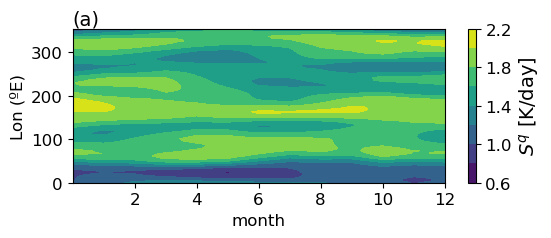

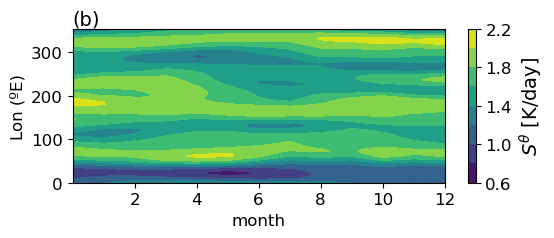

In [8]:
function plot_first_year(months_fine, S, cbar_label, plot_label)
    # profiles are saved in an array (time, space) with Δt = 1.7 hours 
    # find the indices (along the first axis) that belong to the first year of simulation
    idx_first_year = findall(x -> x < 12, floor.(Int, months_fine))
    time_ = months_fine[idx_first_year]

    # Spatial discretization 
    space_ = range(0, stop = 360 - 360 / 64.0, length = 64)
    
    # Mesh
    X = repeat(reshape(space_, 1, :), length(time_))
    Y = repeat(time_, 1, length(space_))

    # Plotting
    fig, ax = subplots(1, 1, figsize = (6, 2))
    im1 = ax.contourf(Y', X', 15.0 * 24.0 / Tₐ .* S[idx_first_year, :]') # dimensionalize Sq for plotting

    # Colorbar and labels
    cbar1 = colorbar(im1)
    cbar1.set_label(cbar_label, fontsize = 14)

    ax.set_xlabel("month", fontsize = 12)
    ax.set_ylabel("Lon (ºE)", fontsize = 12)
    ax.text(0, 365, plot_label, fontsize = 14)
    ax.tick_params(axis = "both", which = "major", labelsize = 12)

    # Customize colorbar ticks
    cbar1.ax.locator_params(nbins = 5)
    cbar1.ax.tick_params(labelsize = 12)

end

plot_first_year(months_fine, Sq, L"$S^q$ [K/day]", "(a)")
plot_first_year(months_fine, Stheta, L"$S^\theta$ [K/day]", "(b)")


## 1. Set Initial Conditions

simulations are initialized with the wavenumber-2 solution to the linearized system


∂ₜK + ∂ₓK = -1/√2 ̄HA


∂ₜR - 1/3*∂ₓR = -2√2/3 ̄HA


∂ₜQ + ̄Q/√2∂ₓK - Q/6√2∂ₓR = (̄Q/6 - 1)̄HA


∂ₜA = ΓQ<Aₛ>

In [15]:
# The wavenumber-2 eigenmode is selected to initialize model.
k=2;
κ2= 2*π*im*2/L;
Mat = -im.*[κ2           0.0           0.0                1/√2*Hbar;
            0.0         -1/3.0*κ2      0.0                2*√2/3.0*Hbar;
            Qbar/√2*κ2  -Qbar/6/√2*κ2  0.0               -(Qbar/6.0- 1.0)*Hbar;
            0.0          0.0           -Γ*(mean(Aₛ[1,:], dims=1))/γ         0.0];
                      
d, V = eigen(Mat); # eignevalues (frequencies) in ascending order

#select MJO mode (slowest eastward propagating wave of the model)
MJO_vec= V[:,3];

initampl = 0.05; 

xx = collect(0:Nx-1)*dx;

K0 = initampl*MJO_vec[1]*exp.(κ2*xx);
R0 = initampl*MJO_vec[2]*exp.(κ2*xx);
Q0 = initampl*MJO_vec[3]*exp.(κ2*xx);
A0 = initampl*MJO_vec[4]*exp.(κ2*xx); 


K0_ref = K0;
R0_ref = R0;
Q0_ref = Q0*γ;
A0_ref = A0*γ .+ real.(mean(Aₛ[:,:], dims = 1)[1,:]); # add background
theta = -1/√2 * (K0_ref .+ R0_ref./2.0).*γ .+ R0_ref./4.0.*γ./√2 ; 
Z0_ref = Q0_ref .+ Qbar.*theta;

## 2. Model integration

In [ ]:
NUM_REPEAT = 15 # number of independent runs (! different from REPEAT variable which defines the thermalization period and thus the total length of simulation: Nt)

# store every time step
AA = zeros(Nx,NUM_REPEAT,Nt);
KK = zeros(Nx,NUM_REPEAT,Nt);
RR = zeros(Nx,NUM_REPEAT,Nt);
ZZ = zeros(Nx,NUM_REPEAT,Nt);

# store time steps
times_ = range(Δt, step = Δt, length = Nt)

for nr in (1:NUM_REPEAT)
    
    # initial conditions   
    K0 = real(K0_ref); 
    R0 = real(R0_ref); 
    Q0 = real(Q0_ref); 
    A0 = real(A0_ref); 
    Z0 = real(Z0_ref); 
    
    for tt in (1:Nt)
            
        if dostocha==1
            K1, R1, A1, Z1 = ev_functions.evolve_stocha(K0, R0, Z0, A0, Hbar, Qbar, Stheta[tt,:], Sq[tt,:], Γ, Δt, κ, Δa, Nx);
        else
            K1, R1, A1, Z1 = ev_functions.evolve(K0, R0, Z0, A0, Hbar, Qbar, Stheta[tt,:], Sq[tt,:], Γ, Δt, κ, dx);
        end
        K0 = K1; R0 = R1; Z0 = Z1; A0 = A1;
        
        
        AA[:,nr,tt]=real(A0[:,:]);
        KK[:,nr,tt]=real(K0[:,:]);
        RR[:,nr,tt]=real(R0[:,:]);
        ZZ[:,nr,tt]=real(Z0[:,:]);     
    end   
end

# identify the date that goes with each element of the time array
month_idx = floor.(Int, months_fine);
dates_array = [dates_tmp[i+1] for i in month_idx];
month_array = [dates_tmp[i+1].month for i in month_idx];
year_array = [dates_tmp[i+1].year for i in month_idx];

# find the last 43 years (1979 - 2021)
itk = length(year_array);
while(year_array[itk]>d1_y) # d1_y = 1979
    itk=itk-1;
end
while(year_array[itk]==d1_y) # d1_y = 1979
    itk=itk-1;
end
itk = itk+1;

dates_output = dates_array[itk:end]; 
times = times_[itk:end];

# select last 43 years of the simulation outputs
AA = AA[:,:,itk:end]; 
KK = KK[:,:,itk:end]; 
RR = RR[:,:,itk:end];
ZZ = ZZ[:,:,itk:end]; 


# free memory
K0 = nothing;
R0 = nothing;
Q0 = nothing;
A0 = nothing;
Z0 = nothing;

K0_ref = nothing;
R0_ref = nothing;
Q0_ref = nothing;
A0_ref = nothing;
Z0_ref = nothing;


LoadError: InterruptException:

In [ ]:
# recover variables in dimensional units
u = (1/√2 .*(KK .- RR./2.0)*γ .- (RR/4.0).*(γ/√2))*50; #[m/s] ϕ₀(0)= γ = (π)^(-1/4.) 
theta = -1.0/√2 .*(KK .+RR./2.0)*γ .+ (RR/4.0).*(γ/√2);
q = (ZZ .- Qbar*theta)*15; # [K]
theta = theta*15; # [K]
ha = Hbar.* AA*15.0*24.0/Tₐ; # [K/day]

In [ ]:
# Filter intraseasonal signal in the data 
sim_day, months_tracked, u_daily, u_daily_filtered, ha_daily, ha_daily_filtered, q_daily, q_daily_filtered, theta_daily, theta_daily_filtered = 
    filters.filter(
        month_array[itk:end], u, theta, q, ha, Qbar, Hbar, γ, Tₐ, times, length(times), Nx, NUM_REPEAT
        );


sim_day = floor.(times*Tₐ/24)
months_tracked_ = zeros(length(unique(sim_day))) # for each simulation day we'll need to know to which month it corresponds
years_tracked = zeros(length(unique(sim_day))) # and to which year
i=1
for d in unique(sim_day)
    idxs = findall(sim_day .== d);
    months_tracked_[i] = mean(month_array[itk:end][idxs]); 
    years_tracked[i] = mean(year_array[itk:end][idxs]);
    i+=1;
end
sim_day = unique(sim_day);



Nd = size(sim_day)[1]; # number of simulation days


# save("./data/variables.jld", "u_daily", u_daily, "u_daily_filtered", u_daily_filtered, "ha_daily", ha_daily, "ha_daily_filtered", ha_daily_filtered)

## 3. Plot model output

### 3.1 Space-time evolution of u and ha (without and with spatio-temporal filtering)


In [ ]:

# apply spatial filter to the temporally (intraseasonally) filtered fields 

u_daily_filtered_space = zeros(size(u_daily_filtered));
ha_daily_filtered_space = zeros(size(ha_daily_filtered));

Nd = size(ha_daily)[3];

maxk=4 # max wave number (planetary waves)
for nr in 1:NUM_REPEAT
    for ts in 1:Nd # filter each time step separately
        # wind
        fH = fftshift(fft(u_daily_filtered[:,nr,ts]));   
        freqs = fftshift(fftfreq(Nx, Nx));
        idx1 = findall(x-> abs(x) >=maxk , freqs);
        fH[idx1].=0;
        u_daily_filtered_space[:,nr,ts] = real(ifft(ifftshift(fH)));
        
        # convective activity
        fH = fftshift(fft(ha_daily_filtered[:,nr,ts]));   
        freqs = fftshift(fftfreq(Nx, Nx));
        idx1 = findall(x-> abs(x) >=maxk , freqs);
        fH[idx1].=0;
        ha_daily_filtered_space[:,nr,ts] = real(ifft(ifftshift(fH)));
    end
end



In [ ]:
time_ = 1:360; 
space_ = range(0, stop=360-360/64.0, length=64) 
X = repeat(reshape(space_, 1, :), length(time_), 1);
Y = repeat(time_, 1, length(space_));


nr = 15
year = 2005.0; 
interval = findall(x->x==year, years_tracked);
fig, axs = subplots(1,4, figsize = (6,6))
im1 = axs[1].contourf(X,Y, u_daily[:,nr,interval]', levels = LinRange(-40, 40, 9) )
im2 = axs[2].contourf(X,Y, ha_daily[:,nr,interval]', levels = LinRange(0, 25, 6))
im3 = axs[3].contourf(X,Y, u_daily_filtered_space[:,nr,interval]', levels = LinRange(-10, 10, 7))
im4 = axs[4].contourf(X,Y, ha_daily_filtered_space[:,nr,interval]', levels = LinRange(-2, 2, 6))

p1 = axs[1].get_position().get_points()
p1 = [(p1...)...]
p2 = axs[2].get_position().get_points()
p2 = [(p2...)...]
p3 = axs[3].get_position().get_points()
p3 = [(p3...)...]
p4 = axs[4].get_position().get_points()
p4 = [(p4...)...]



ax_cbar1 = fig.add_axes([p1[1], -0.04, p1[2]-p1[1], 0.05])
ax_cbar2 = fig.add_axes([p2[1], -0.04, p2[2]-p2[1], 0.05])
ax_cbar3 = fig.add_axes([p3[1], -0.04, p3[2]-p3[1], 0.05])
ax_cbar4 = fig.add_axes([p4[1], -0.04, p4[2]-p4[1], 0.05])


cbar1 = colorbar(im1, cax=ax_cbar1, orientation="horizontal")
cbar2 = colorbar(im2, cax=ax_cbar2, orientation="horizontal")
cbar3 = colorbar(im3, cax=ax_cbar3, orientation="horizontal")
cbar4 = colorbar(im4, cax=ax_cbar4, orientation="horizontal")

ax_cbar1.set_xticklabels(ax_cbar1.get_xticklabels(), rotation=90)
ax_cbar2.set_xticklabels(ax_cbar2.get_xticklabels(), rotation=90)
ax_cbar3.set_xticklabels(ax_cbar3.get_xticklabels(), rotation=90)
ax_cbar4.set_xticklabels(ax_cbar4.get_xticklabels(), rotation=90)


ax_cbar1.set_xlabel(L"$u$ [m/s]")
ax_cbar2.set_xlabel(L"$\bar{H}a$ [K/s]")
ax_cbar3.set_xlabel(L"filt. $u$ [m/s]")
ax_cbar4.set_xlabel(L"filt. $\bar{H}a$ [K/s]")


axs[1].set_ylabel("day")

axs[1].set_xlabel("Lon (ºE)")
axs[2].set_xlabel("Lon (ºE)")
axs[3].set_xlabel("Lon (ºE)")
axs[4].set_xlabel("Lon (ºE)")

axs[2].set_yticks([])
axs[3].set_yticks([])
axs[4].set_yticks([])


axs[1].text(1, 362, "(a)")
axs[2].text(1, 362, "(b)")
axs[3].text(1, 362, "(c)")
axs[4].text(1, 362, "(d)")


# plot speed indications on panel (d) - change/adapt by hand 
a = -90/360;
b = 345;
line1 = a.*space_.+b;
axs[4].plot(space_[21:51], line1[21:51], color = "white", linestyle = "--", linewidth = 1.2)
axs[4].text(40, 275, "-5.1 m/s", color = "white")


a = 70/360;
b = -5;
line2 = a.*space_.+b;
axs[4].plot(space_[11:61], line2[11:61], color = "white", linestyle = "--", linewidth = 1.2)
axs[4].text(40, 45, "6.6 m/s", color = "white")



### 3.2 Spatio-temporal spectrum

In [39]:
function padreplicate(a, padSize)
    # Pad an array by replicating values.
    numDims = length(padSize);
    idx = [];
    for k = 1:numDims
        M = size(a)[k];
        onesVector = ones(Int, padSize[k]);
        push!(idx, vcat(onesVector, (1:M), M .*onesVector));
    end   
    return a[idx[1], idx[2]]
end
    

function spectrum(term, Nx, nd)
    
    for iii in 1:Nx
        term[iii,:] = term[iii,:] .- mean(term[iii,:]);
    end
    termhat = fftshift(fft(term)); term = 0;
    term = termhat.*conj(termhat)/nd/Nx/nd/Nx; termhat=0;
    term = log10.(term);
    return term
end


In [ ]:
nxsmoo=     1; # x size of smooth (odd) (ref=1)
ntsmoo=     51; # t size of smooth (odd) (ref=25)
undersamplext=    1 ; # undersample outputs to be faster
nku=1; # k-space between samples 
nwu=11; # w-space between samples 

tcon=vcat(zeros(1),0:Nd-1);
ts = tcon; tcon = 0;

kg =-fftshift(fftfreq(Nx,Nx));
NNd = length(ts);
wg = fftshift(fftfreq(NNd,NNd))/NNd;


####################################
term = ha_daily[:,1,:];
xcon=((1:Nx)*0);
xcon=hcat(xcon,term);  
term_all = xcon; xcon = 0;

for nr in 2:NUM_REPEAT
    term = ha_daily[:,nr,:];
    
    xcon=((1:Nx)*0);
    xcon=hcat(xcon,term);  
    term = xcon; xcon = 0;
    
    term_all = term_all .+ spectrum(term, Nx, Nd)
end
term = term_all./NUM_REPEAT;
term_all = 0;

#############################

# smooth data
sz = [nxsmoo,ntsmoo]'; # x size of smooth, t size of smooth
padSize = Int.((sz .-1) ./2);
smooth_ = ones((sz[1],sz[2])) ./ (sz[1]*sz[2]); 

# pad data
X = padreplicate(term,padSize);
# perform the convolution
Y = conv(X, smooth_)  # Convolution (1 dimensional convolution, I think)

# Extract the 'valid' part of the result
Y_valid = Y[:,1:size(X)[2]];
Y_valid = Y_valid[:,padSize[2]+1:end-padSize[2]];

# undersample for figure
PSD=real.(Y_valid[1:nku:end,1:nwu:end]);
kg=kg[1:nku:end];
wg=wg[1:nwu:end]; 


################################

# graph ranges
xxrange=[-5,5]; yyrange=[1/100,0.1]; 
kwlevels= -7.5:0.5:-3;

# figure
fig = figure(figsize=(8,6))

aspect_ratio = (5 - (-5)) / (0.1 - (1 / 100))
contourf(kg, wg, PSD', levels = kwlevels,  cmap = :jet)
cbar = colorbar()

axhline(y = 1/30, linestyle = "--", color = "black")
text(3.2, 0.0345, "30 days", fontsize=16)
axhline(y = 1/90, linestyle = "--", color = "black")
text(3.2, 0.0125, "90 days", fontsize=16)

xlabel("k (2pi/40000km)", fontsize=18)
ylabel("freq (cpd)", fontsize=18)

xlim(xxrange)
ylim(yyrange)

cbar.set_ticks([-7,-6,-5,-4, -3])
cbar.set_label(L"Log(Power of $\bar{H}a$)", fontsize=18)
cbar.ax.tick_params(labelsize=16)

tick_params(axis="both", which="major", labelsize=16)



## 4. Skeleton Multivariate MJO Index and identification of MJO events

### 4.1 Compute SMM

In [429]:
# for each independent repetition of the simulation, compute Principal Components and SMM index values 
Nd = size(ha_daily)[3];
SMM1 = zeros(NUM_REPEAT, Nd);
SMM2 = zeros(NUM_REPEAT, Nd);
amplitude = zeros(NUM_REPEAT, Nd);
phase = zeros(NUM_REPEAT, Nd);

i=1
var1, var2, PC1, PC2, amplitude[1,:], phase[1,:], SMM1[1,:], SMM2[1,:] = smm.SMM(sim_day, u_daily_filtered[:,i,:], ha_daily_filtered[:,i,:]); 
for i in 2:NUM_REPEAT
    var1_tmp, var2_tmp, PC1_tmp, PC2_tmp, amplitude[i,:], phase[i,:], SMM1[i,:], SMM2[i,:] = smm.SMM(sim_day, u_daily_filtered[:,i,:], ha_daily_filtered[:,i,:]); 
    var1 = var1 + var1_tmp;
    var2 = var2 + var2_tmp;
    PC1 = PC1 .+ PC1_tmp;
    PC2 = PC2 .+ PC2_tmp;
end

# compute mean PC and variance over the 15 independent runs (for plotting)
var1 = var1 / NUM_REPEAT;
var2 = var2 / NUM_REPEAT;
PC1 = PC1 ./ NUM_REPEAT;
PC2 = PC2 ./ NUM_REPEAT;

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

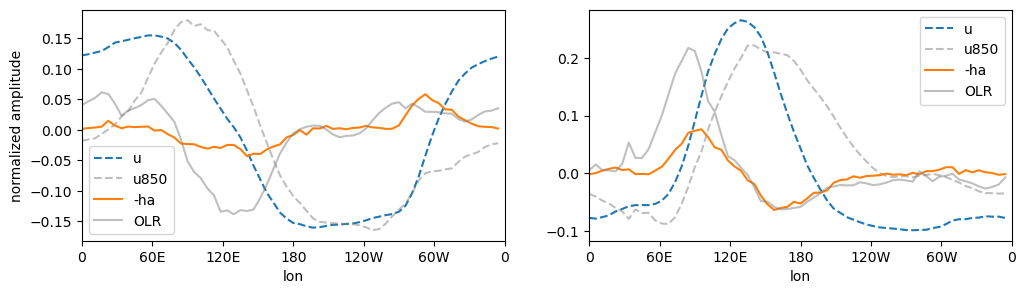

In [430]:
# plot EOFs (mean over the 15 independent runs)

fig, axs = subplots(1,2, figsize = (14,3))

axs[1].plot(longitudes, PC1[1:64]./var1, label = L"$u$", color = "steelblue")
axs[1].plot(longitudes, PC1[65:end]./var1, label = L"$-\bar{H}a$", color = "tomato")
axs[2].plot(longitudes, PC2[1:64]./var2, label = L"$u$", color = "steelblue")
axs[2].plot(longitudes, PC2[65:end]./var2, label = L"$-\bar{H}a$", color = "tomato")


axs[1].text(1, 1.4, "EOF1", fontsize = 16)
axs[2].text(1, 2.68, "EOF2", fontsize = 16)


axs[1].set_xlabel("lon", fontsize=14)
axs[2].set_xlabel("lon", fontsize=14)

axs[1].set_ylabel("normalized amplitude", fontsize=14)

axs[1].legend(fontsize=14, loc="upper right")
axs[2].legend(fontsize=14)

axs[1].set_xlim([0, 354])
axs[2].set_xlim([0, 354])

axs[1].set_xticks([0, 60, 120, 180,240, 300])
axs[1].set_xticklabels(["0", "60E", "120E", "180", "120W", "60W"]) 

axs[2].set_xticks([0, 60, 120, 180,240, 300])
axs[2].set_xticklabels(["0", "60E", "120E", "180", "120W", "60W"]) 

axs[1].tick_params(axis="both", which="major", labelsize=14)
axs[2].tick_params(axis="both", which="major", labelsize=14)



### 4.2 Identify MJO events from SMM data


In [672]:
seqs = [] # contains events for each independent run. Event = (starting,ending) day.
for nr in 1:NUM_REPEAT
    seq = events.identify(amplitude[nr,:], phase[nr,:]);
    push!(seqs,seq);
end

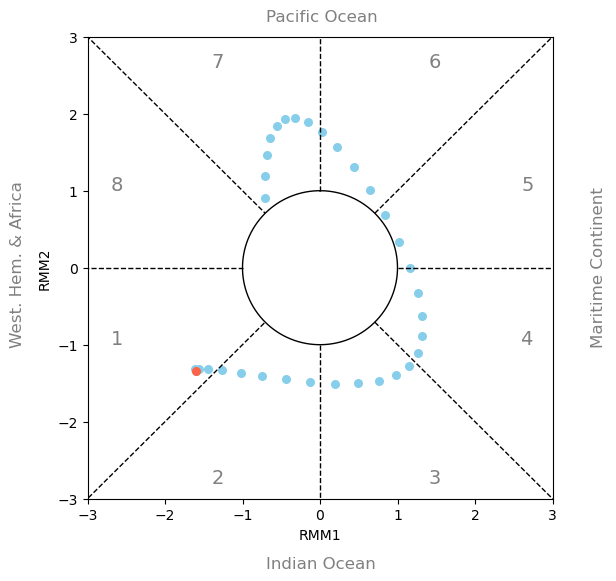

In [674]:
# select one event and plot its phase-space diagram
run_number = 1;
ii1 = seq[1][1,:][1];
ii2 = seq[1][1,:][2];
events.phase_space_diagram(SMM1[run_number,:], SMM2[run_number,:], ii1, ii2, amplitude[15,:])

## 5. Compute and visualize characteristics of simulated MJO events

### 5.1 Number of events

In [ ]:
# mean number of events and standard deviation over all independent runs
num_events = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    num_events[nr] = events.number(seqs[nr]);
end
mean_num_events = mean(num_events);
std_num_events = std(num_events);
println("Average total number of events :", mean_num_events, " +/- ", std_num_events/sqrt(NUM_REPEAT))
println("Average number of events per year : ", mean_num_events/(Nd/365), " +/- ",  std(num_events/sqrt((Nd/365))))

### 5.2 Seasonal variability

In [690]:
# count number of MJO events in each month (simulation)
seasonal_var = zeros(12);
for nr in 1:NUM_REPEAT
    seq = seqs[nr];
    seasonal_var += events.seasonality(seq, months_tracked);
end

# seasonality from observation (computed elsewhere)
seasonal_ref = [34.0, 30.0, 41.0, 38.0, 39.0, 25.0, 11.0, 9.0, 14.0, 28.0, 25.0, 35.0];


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


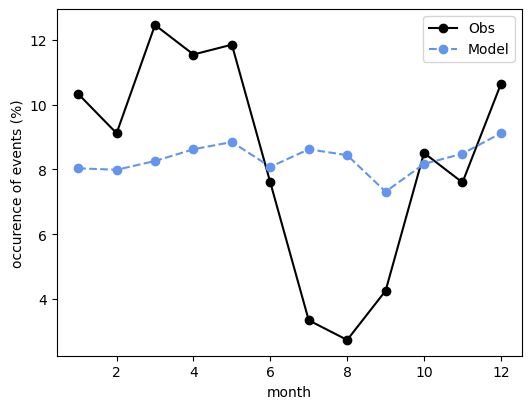

In [733]:
fig, ax = subplots(1,1, figsize = (4*1.5,3*1.5))

ax.plot(1:12,seasonal_ref./sum(seasonal_ref)*100, "-o", label = "Obs", color = "black") 
ax.plot(1:12,seasonal_var./sum(seasonal_var)*100, "--o", label = "Model", color = "cornflowerblue") 

ax.set_xlabel("month")
ax.set_ylabel("occurence of events (%)")

ax.legend()

### 5.3 Duration, total angle in (SMM1,SMM2) space, maximum SMM amplitude

In [735]:
########################################################
# DURATION 
########################################################
durations = [];
mean_durations = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    durations_nr = events.duration(seqs[nr]);
    append!(durations, durations_nr);
    mean_durations[nr] = mean(durations_nr);
end

mean_duration = mean(mean_durations);
std_duration = std(mean_durations);

println("Mean duration :", mean_duration, " +/- ", std_duration/sqrt(NUM_REPEAT), " vs ", mean_duration_ref, " in reality.")


########################################################
# ANGLES
########################################################
angles = [];
mean_angles = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    angles_nr = events.total_angle(seqs[nr], phase[nr,:]);
    append!(angles, angles_nr);
    mean_angles[nr] = mean(angles_nr);
end

mean_angle = mean(mean_angles);
std_angle = std(mean_angles ./2 ./pi);

println("Mean angle :", mean_angle/2/pi, " +/- ", std_angle/sqrt(NUM_REPEAT), " * 2pi vs ", mean_angle_ref/2/pi, " *2pi in reality.")


########################################################
# MAXIMUM SMM
########################################################
maxRMMs = [];
mean_maxRMMs = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    maxRMMs_nr, loc = events.max_amplitude(seqs[nr], amplitude[nr,:], phase[nr,:]);
    append!(maxRMMs, maxRMMs_nr);
    mean_maxRMMs[nr] = mean(maxRMMs_nr);
end

mean_maxRMM = mean(mean_maxRMMs);
std_maxRMM = std(mean_maxRMMs);

println("Mean of the maximum values of RMM :", mean_maxRMM, " +/- ", std_maxRMM/sqrt(NUM_REPEAT), " vs ", mean_maxRMM_ref, " in reality.")



########################################################
# reference values from observation - computed elsewhere
########################################################


duration_ref = [43.0, 51.0, 35.0, 38.0, 48.0, 20.0, 18.0, 34.0, 19.0, 18.0, 21.0, 42.0, 65.0, 70.0, 18.0, 20.0, 18.0, 39.0, 36.0, 43.0, 36.0, 26.0, 39.0, 22.0, 31.0, 14.0, 37.0, 45.0, 29.0, 21.0, 76.0, 16.0, 48.0, 52.0, 153.0, 24.0, 14.0, 54.0, 40.0, 21.0, 21.0, 29.0, 18.0, 30.0, 23.0, 45.0, 41.0, 24.0, 32.0, 23.0, 43.0, 35.0, 23.0, 16.0, 51.0, 41.0, 43.0, 47.0, 24.0, 44.0, 64.0, 17.0, 43.0, 17.0, 25.0, 75.0, 25.0, 27.0, 35.0, 39.0, 81.0, 60.0, 31.0, 32.0, 24.0, 40.0, 14.0, 25.0, 85.0, 29.0, 46.0, 20.0, 15.0, 14.0, 65.0, 22.0, 77.0, 30.0, 25.0, 31.0, 20.0, 24.0, 70.0, 23.0, 14.0, 51.0, 26.0, 50.0, 30.0, 24.0, 37.0, 19.0, 100.0, 25.0, 41.0, 48.0, 29.0, 52.0, 29.0, 40.0, 21.0, 29.0, 29.0, 17.0, 17.0, 12.0, 19.0, 23.0, 32.0, 28.0, 86.0, 25.0, 81.0, 13.0, 29.0, 28.0, 28.0, 16.0, 25.0, 38.0, 38.0, 62.0, 45.0, 40.0, 26.0, 25.0, 19.0, 55.0, 25.0, 14.0, 89.0, 26.0, 33.0, 23.0, 73.0, 56.0, 49.0, 22.0, 47.0, 20.0, 64.0, 11.0, 37.0];
angle_ref = [8.231361433980151, 6.521913674678556, 4.937017439860323, 2.618226747303696, 5.706097255485039, 3.730330878309978, 2.633462368347161, 5.408194160006371, 2.956117791002831, 3.5618588414097965, 2.8872830332496444, 3.7839027323578986, 5.553338762188588, 6.841554694360584, 3.6057756256524347, 3.4274333776136667, 2.6141842718143913, 6.552369697082918, 3.9269210269915673, 5.2888599039434085, 4.617199937606468, 3.746135696437136, 5.637561733489105, 2.3960088468369354, 4.090287590407964, 2.43081649403295, 4.853887796727675, 3.0620697825564944, 3.168755379906231, 2.4718202325857392, 9.37262907567839, 3.872392809929147, 4.971801147025561, 6.608608184067237, 21.209269111460685, 4.868761227527477, 2.5165781009680463, 7.923671223634278, 2.59677984127235, 2.81386676945623, 3.14234826245822, 2.4218733054948225, 2.45068034970608, 4.749885857483365, 2.5410377691324246, 6.909045162995007, 6.319761076064756, 5.019348616137907, 4.847470307310038, 2.6663179626412434, 4.076564382369301, 4.1269530453301515, 2.4564385001992144, 2.5782776978893773, 8.15715119076666, 2.545396290471709, 5.32453927945679, 6.300756483517633, 3.509313436653891, 5.732763590042552, 5.592491016078137, 2.970904829508907, 6.493083833421072, 3.817282665232919, 2.56629994895041, 8.68796385224021, 2.5327228929215897, 2.5265597305042133, 3.436686937017445, 3.7097553548905937, 11.695544963750262, 4.214625716440128, 3.025691583987051, 3.6883205117187376, 3.0226759635853955, 4.7923788711573, 2.751019351875076, 4.246793293722759, 10.945866405251408, 4.33171905482677, 5.94549109321282, 2.6084162514964118, 2.4885666893241023, 3.0275241995686066, 5.6755845252091355, 3.1870126281239854, 8.962267446391477, 4.229345892465792, 3.6507747266569206, 2.7579345304254343, 3.4943697814461525, 3.574236643329646, 12.032264358147495, 3.5482172743092724, 3.1057751250566, 7.303924432831236, 3.000111986420371, 6.47164866541652, 2.4571058875569314, 3.0691065931853645, 4.082680538059893, 2.4654836674739373, 15.387221661985624, 3.1419969305641113, 5.546615828836607, 3.848135840141258, 3.851286232953449, 7.919710064372241, 2.608563977974617, 5.940693324369062, 3.9838619367388524, 2.686943039155107, 4.099183167920551, 2.564227516023216, 2.936055908898063, 2.461648510966678, 2.9854359685748775, 3.9650343297618256, 3.6746978841251288, 4.092356318315287, 9.960910355342008, 3.141345096795246, 10.413694510310032, 2.8185458226631854, 4.67062663983932, 2.4419568744719813, 3.5038024426000836, 2.919586105680818, 4.142248114574398, 3.4726653676834345, 5.486213696481422, 6.652712597446654, 4.913627678106008, 4.045225908576436, 3.9860825235965907, 4.299087869372429, 4.384123250908747, 8.784150516065235, 2.8695463855093584, 2.7456236840881276, 9.498597891595077, 4.142314719616992, 4.188926038573834, 2.486364135074254, 12.43424080538299, 6.365098868165704, 6.409129245882047, 3.017089076920911, 8.61640860271514, 3.429046931688904, 8.413805938516958, 2.418700133093108, 3.818995554912695];
maxRMM_ref = [2.8529141945094234, 3.18326593020001, 2.5730672159972334, 2.560453311046767, 2.2804545157560936, 1.971703503311463, 2.0038653150692847, 2.0916943290493095, 1.7941247655599992, 1.9217307832035093, 1.6750912831782776, 1.9899673658656858, 2.82319261847022, 3.9708496986795225, 1.8870949066161524, 1.2847433960800845, 2.140783336210209, 2.8297045709235054, 3.5423592911068806, 2.956217317054722, 2.5047275274371223, 2.3331720338364117, 2.771639317287604, 1.6990171781404992, 2.0226191881560807, 1.7402078855941228, 2.7415565215308804, 2.357066611810372, 2.7724097222934936, 2.195449017116233, 3.896407356878224, 2.0856834149757697, 2.6891576957312022, 2.3173939335646336, 3.265115165621057, 2.079595043964809, 1.7486135756017074, 2.795104689224681, 2.5619356770708803, 1.8721983601892955, 2.2818496196300964, 2.4753835615512276, 1.9583233257580688, 2.537549690595498, 1.5508672553707283, 3.166442387418856, 2.0400039555746234, 2.3576913349121105, 2.874445852232285, 2.541863116851165, 2.949054834557202, 2.0724380075341884, 2.0703579699722017, 2.624274422133287, 2.0852844277879146, 2.1303913035675723, 2.373917315834209, 2.543224663994461, 2.9964344737692907, 3.520006378222405, 3.800923164693433, 2.60556087425328, 3.122265150553778, 1.9729803361381917, 3.5659960188729936, 3.1073034505660924, 2.157956443776215, 1.583059337460059, 2.4404292404758308, 2.5590314475439135, 2.2478005958166465, 2.780986881347609, 2.4501448409456783, 2.131476217705569, 2.118353039047557, 1.8845300343972133, 1.8191631655362426, 2.864190069680494, 2.952905909983812, 2.296241340914584, 2.553170322084152, 2.865093705221746, 2.3105945133326355, 1.8758087262845318, 3.383564380431967, 1.7694720035492308, 2.8754769010212016, 3.0391943842181783, 2.4686515140475223, 1.9754037455421969, 2.015966573145378, 2.084164317840185, 3.6698532917160174, 2.668967855457301, 1.388626810464249, 2.6374714259476675, 1.7313229547266635, 2.9702649594949446, 2.818902440179339, 2.5522358173086026, 2.3434446325003737, 2.543913161140251, 3.278273557472131, 2.7862559915853278, 3.08755017370794, 2.2937431337407754, 2.430346166131975, 2.799555314706407, 2.1678273698895554, 2.439334947615954, 2.0666798318960473, 2.25962043386393, 1.833490015655922, 2.2128995620121876, 2.8421255487802664, 1.2920688895986627, 1.8628646534010889, 2.4552598846922047, 3.563406316238361, 2.3242471921134844, 3.3994434336172428, 2.0537035808016015, 2.621492765799604, 2.4401461834476734, 2.2041104031392176, 2.5935076263685386, 2.2740592706180744, 2.6645713541462843, 2.4790034836630594, 2.920108837982375, 4.5766515406081, 3.961270367213301, 2.8439270229463807, 2.725983984004178, 1.6280060828589422, 2.2403566299908007, 2.44036876874557, 3.197680360697932, 3.381162635559701, 1.8128931345067774, 3.8891071364163494, 2.5133953604878534, 2.2416880576224805, 1.970546214688921, 3.0679172782364685, 2.6905302119439924, 2.8795924737974157, 2.7314653618524254, 2.114683257621139, 2.020416701896634, 3.4064205896932926, 2.0757931592471257, 1.7779832234397304];

mean_duration_ref = mean(duration_ref);
mean_angle_ref = mean(angle_ref);
mean_maxRMM_ref = mean(maxRMM_ref);


Mean duration :39.566329442883834 +/- 2.9549908284673183 vs 36.12418300653595 in reality.


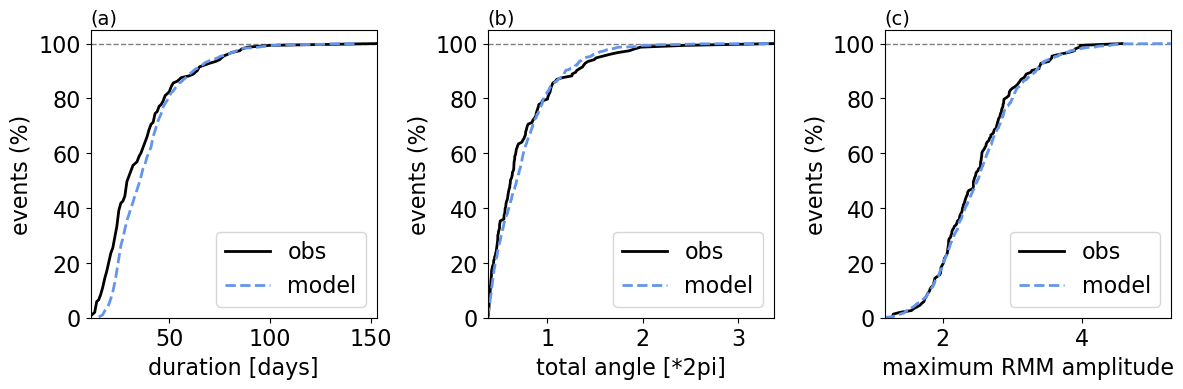

In [738]:
# plot statistics
fig, axs = subplots(1,3, figsize = (12,4))

#######################################################################################################
axs[1].axhline(y = 100, linestyle = "--", color = "grey", linewidth = 1)


duration_sorted = sort(duration_ref);
data = [];
for m in duration_sorted
    cdf = sum(duration_sorted .<= m)
    data = vcat(data, cdf/size(duration_ref)[1])
end

axs[1].plot(duration_sorted, data*100, color="black", alpha=1, linewidth=2, label = "obs")

duration_sorted = sort(durations);
data = [];
for m in duration_sorted
    cdf = sum(duration_sorted .<= m)
    data = vcat(data, cdf/size(durations)[1])
end

axs[1].plot(duration_sorted, data*100, linestyle = "--", color="cornflowerblue", alpha=1, linewidth=2.5, label = "model")


axs[1].set_xlabel("duration [days]", fontsize = 16)
axs[1].set_ylabel("events (%)", fontsize = 16)
axs[1].tick_params(axis="both", labelsize=16)

min_d = minimum([durations; duration_ref])
max_d = maximum([durations; duration_ref])

axs[1].set_xlim([min_d,max_d])
axs[1].set_ylim([0,105])
axs[1].legend(fontsize=16, loc = "lower right")


########################################################################################################

axs[2].axhline(y = 100, linestyle = "--", color = "grey", linewidth = 1)


total_angle_sorted = sort(angle_ref./2/pi);
data = [];
for m in total_angle_sorted
    cdf = sum(total_angle_sorted .<= m)
    data = vcat(data, cdf/size(angle_ref)[1])
end

axs[2].plot(total_angle_sorted, data*100, color="black", alpha=1, linewidth=2, label = "obs")

total_angle_sorted = sort(angles./2/pi);
data = [];
for m in total_angle_sorted
    cdf = sum(total_angle_sorted .<= m)
    data = vcat(data, cdf/size(angles)[1])
end

axs[2].plot(total_angle_sorted, data*100, linestyle = "--", color="cornflowerblue", alpha=1, linewidth=2.5, label = "model")


axs[2].set_xlabel("total angle [*2pi]", fontsize = 16)
axs[2].set_ylabel("events (%)", fontsize = 16)
axs[2].tick_params(axis="both", labelsize=16)

min_a = minimum([angles; angle_ref])
max_a = maximum([angles; angle_ref])

axs[2].set_xlim([min_a./2/pi, max_a./2/pi])
axs[2].set_ylim([0,105])
axs[2].legend(fontsize=16, loc = "lower right")


########################################################################################################

axs[3].axhline(y = 100, linestyle = "--", color = "grey", linewidth = 1)

max_amplitude_sorted = sort(maxRMM_ref);
data = [];
for m in max_amplitude_sorted
    cdf = sum(max_amplitude_sorted .<= m)
    data = vcat(data, cdf/size(maxRMM_ref)[1])
end
#data = [data]

axs[3].plot(max_amplitude_sorted, data*100, color="black", alpha=1, linewidth=2, label = "obs")

RMM_sim_sorted = sort(maxRMMs);
data = [];
for m in RMM_sim_sorted
    cdf = sum(RMM_sim_sorted .<= m)
    data = vcat(data, cdf/size(maxRMMs)[1])
end

axs[3].plot(RMM_sim_sorted, data*100, linestyle = "--", color="cornflowerblue", alpha=1, linewidth=2.5, label = "model")


axs[3].set_xlabel("maximum RMM amplitude", fontsize = 16)
axs[3].set_ylabel("events (%)", fontsize = 16)
axs[3].tick_params(axis="both", labelsize=16)

min_r = minimum([maxRMMs; maxRMM_ref])
max_r = maximum([maxRMMs; maxRMM_ref])

axs[3].set_xlim([min_r,max_r])
axs[3].set_ylim([0,105])
axs[3].legend(fontsize=16, loc = "lower right")

########################################################################################################

axs[1].text(min_d, 107, "(a)", fontsize=16)
axs[2].text(min_a/2/pi, 107, "(b)", fontsize=16)
axs[3].text(min_r, 107, "(c)", fontsize=16)


########################################################################################################
tight_layout()


### 5.4 Initial and final phases

In [739]:
# number of events starting in each phase
starting_phases_ref = [19.0, 28.0, 20.0, 14.0, 17.0, 21.0, 18.0, 16.0]; # reference from observations - computed elsewhere
starting_phases = zeros(8)
for nr in 1:NUM_REPEAT
    sps = events.starting_phase(seqs[nr], phase[nr,:]);
    starting_phases = starting_phases .+ sps;
end

# number of events ending in each phase
ending_phases_ref = [23.0, 19.0, 12.0, 16.0, 16.0, 20.0, 18.0, 29.0]; # reference from observations - computed elsewhere
ending_phases = zeros(8)
for nr in 1:NUM_REPEAT
    eps = events.ending_phase(seqs[nr], phase[nr,:]);
    ending_phases = ending_phases .+ eps;
end

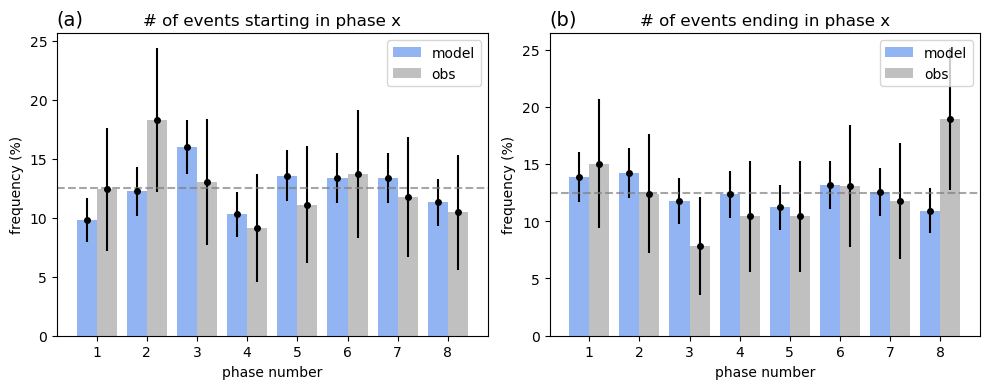

In [787]:
fig, axs = subplots(1,2, figsize = (10,4))


equal_likelyhood = 1/8*100;
width = 0.4


########################################################################################################
total = sum(starting_phases);
total_ref = sum(starting_phases_ref);

error_bars = zeros(8);
for i =1:8
    phat = starting_phases[i]/total
    alpha = 1-0.95;
    zz = 1-alpha/2;
    z = quantile.(Normal(), [zz])
    z = z[1];
    error_bars[i] =  z*sqrt(phat*(1-phat)/total)
end

error_bars_ref = zeros(8);
for i =1:8
    phat = starting_phases_ref[i]/total_ref
    alpha = 1-0.95;
    zz = 1-alpha/2;
    z = quantile.(Normal(), [zz])
    z = z[1];
    error_bars_ref[i] =  z*sqrt(phat*(1-phat)/total_ref)
end


axs[1].bar(0.8:7.8, starting_phases/total*100, width=width, color = "cornflowerblue", alpha = 0.7, label = "model")
axs[1].errorbar(0.8:7.8, starting_phases/total*100, yerr=error_bars*100, fmt="o", color="k", ms = 4)

axs[1].bar(1.2:8.2, starting_phases_ref/total_ref*100, width=width, color = "silver", label = "obs")
axs[1].errorbar(1.2:8.2, starting_phases_ref/total_ref*100, yerr=error_bars_ref*100, fmt="o", color="k", ms = 4)


axs[1].axhline(y = equal_likelyhood, linestyle = "--", color = "grey", alpha = 0.7)
axs[1].set_ylabel("frequency (%)")
axs[1].set_xlabel("phase number")
axs[1].set_title("# of events starting in phase x")
axs[1].legend()

########################################################################################################

# number of events ending in each phase
total = sum(ending_phases)
total_ref = sum(ending_phases_ref);


error_bars = zeros(8);
for i =1:8
    phat = ending_phases[i]/total
    alpha = 1-0.95;
    zz = 1-alpha/2;
    z = quantile.(Normal(), [zz])
    z = z[1];
    error_bars[i] =  z*sqrt(phat*(1-phat)/total)
end

error_bars_ref = zeros(8);
for i =1:8
    phat = ending_phases_ref[i]/total_ref
    alpha = 1-0.95;
    zz = 1-alpha/2;
    z = quantile.(Normal(), [zz])
    z = z[1];
    error_bars_ref[i] =  z*sqrt(phat*(1-phat)/total_ref)
end


axs[2].bar(0.8:7.8, ending_phases/total*100, width=width, color = "cornflowerblue", alpha = 0.7, label = "model")
axs[2].errorbar(0.8:7.8, ending_phases/total*100, yerr=error_bars*100, fmt="o", color="k", ms = 4)
axs[2].bar(1.2:8.2, ending_phases_ref/total_ref*100, width=width, color = "silver", label = "obs")
axs[2].errorbar(1.2:8.2, ending_phases_ref/total_ref*100, yerr=error_bars_ref*100, fmt="o", color="k", ms = 4)

axs[2].axhline(y = equal_likelyhood, linestyle = "--", color = "grey", alpha = 0.7)
axs[2].set_ylabel("frequency (%)")
axs[2].set_xlabel("phase number")
axs[2].set_title("# of events ending in phase x")

axs[2].legend()
########################################################################################################
max_s = axs[1].get_ylim()[2]
max_e = axs[2].get_ylim()[2]

axs[1].text(width/2, max_s + 3/100*max_s, "(a)", fontsize=14)
axs[2].text(width/2, max_e + 3/100*max_e, "(b)", fontsize=14)

########################################################################################################
tight_layout()


## 6. Modulation of MJO by ENSO 

In [742]:
# compute number of MJO events occuring in each phase of ENSO

seqN = [];
seqEN = [];
seqLN = [];
frac = [];
for nr in 1:NUM_REPEAT
    seqN_, seqEN_, seqLN_, frac_ = events.div_seq_ENSO_phases(seqs[nr], years_tracked, months_tracked_, ENSO_ym, ENSO_phases);
    push!(seqN, seqN_);
    push!(seqEN, seqEN_);
    push!(seqLN, seqLN_);
    push!(frac, frac_);
end

In [ ]:
# Average percentage of active MJO days occuring during El Niño, La Niña and Neutral

totN = zeros(NUM_REPEAT);
totEN = zeros(NUM_REPEAT);
totLN = zeros(NUM_REPEAT);
for nr in 1:NUM_REPEAT
    totN_ =0;
    totEN_ =0;
    totLN_ =0;
    for i in 1:size(seqN[nr])[1]
        totN_ += seqN[nr][i,2]-seqN[nr][i,1]+1
    end
    for i in 1:size(seqEN[nr])[1]
        totEN_ += seqEN[nr][i,2]-seqEN[nr][i,1]+1
    end
    for i in 1:size(seqLN[nr])[1]
        totLN_ += seqLN[nr][i,2]-seqLN[nr][i,1]+1
    end
    totN[nr]=totN_;
    totEN[nr]=totEN_;
    totLN[nr]=totLN_;
end

sum_ = totN .+ totEN .+ totLN;

numbers_EN = totEN./sum_;
numbers_LN = totLN./sum_;
numbers_N = totN./sum_;

println("Average percentage of active MJO days occuring during El Niño :", mean(numbers_EN).*100, " +/- ", std(numbers_EN).*100/sqrt(NUM_REPEAT))
println("Average percentage of active MJO days occuring during La Niña :", mean(numbers_LN).*100, " +/- ", std(numbers_LN).*100/sqrt(NUM_REPEAT))
println("Average percentage of active MJO days occuring during Neutral :", mean(numbers_N).*100, " +/- ", std(numbers_N).*100/sqrt(NUM_REPEAT))




### 6.1  Duration of MJO events during El Niño, La Niña and Neutral ENSO 

In [709]:
# Neutral 
durations_N = [];
mean_durations_N = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    durations_nr = events.duration(seqN[nr]);
    append!(durations_N, durations_nr);
    mean_durations_N[nr] = mean(durations_nr);
end

mean_duration_N = mean(mean_durations_N);
std_duration_N = std(mean_durations_N);

println("Mean duration for Neutral events :", mean_duration_N, " +/- ", std_duration_N/sqrt(NUM_REPEAT))

# El Niño
durations_EN = [];
mean_durations_EN = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    durations_nr = events.duration(seqEN[nr]);
    append!(durations_EN, durations_nr);
    mean_durations_EN[nr] = mean(durations_nr);
end

mean_duration_EN = mean(mean_durations_EN);
std_duration_EN = std(mean_durations_EN);

println("Mean duration for El Niño events :", mean_duration_EN, " +/- ", std_duration_EN/sqrt(NUM_REPEAT))


# La Niña
durations_LN = [];
mean_durations_LN = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    durations_nr = events.duration(seqLN[nr]);
    append!(durations_LN, durations_nr);
    mean_durations_LN[nr] = mean(durations_nr);
end

mean_duration_LN = mean(mean_durations_LN);
std_duration_LN = std(mean_durations_LN);

println("Mean duration for La Niña events :", mean_duration_LN, " +/- ", std_duration_LN/sqrt(NUM_REPEAT))


Mean duration for Neutral events :39.59816823851911 +/- 2.272553674325432
Mean duration for El Niño events :38.32813500769383 +/- 4.937385931586896
Mean duration for La Niña events :40.66134474257539 +/- 6.805490151962368


### 6.2 Total angle in (SMM1, SMM2) space during EN, LN and N ENSO

In [ ]:
# Neutral

angles_N = [];

mean_angles_N = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    angles_nr = events.total_angle(seqN[nr], phase[nr,:]);
    append!(angles_N, angles_nr);
    mean_angles_N[nr] = mean(angles_nr);
end

mean_angle_N = mean(mean_angles_N);
std_angle_N = std(mean_angles_N ./2 ./pi);

println("Mean angle for Neutral events:", mean_angle_N/2/pi, " +/- ", std_angle_N/sqrt(NUM_REPEAT), " * 2pi.")


# El Niño
angles_EN = [];

mean_angles_EN = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    angles_nr = events.total_angle(seqEN[nr], phase[nr,:]);
    append!(angles_EN, angles_nr);
    mean_angles_EN[nr] = mean(angles_nr);
end

mean_angle_EN = mean(mean_angles_EN);
std_angle_EN = std(mean_angles_EN ./2 ./pi);

println("Mean angle for El Niño events:", mean_angle_EN/2/pi, " +/- ", std_angle_EN/sqrt(NUM_REPEAT), " * 2pi.")


# La Niña
angles_LN = [];

mean_angles_LN = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    angles_nr = events.total_angle(seqLN[nr], phase[nr,:]);
    append!(angles_LN, angles_nr);
    mean_angles_LN[nr] = mean(angles_nr);
end

mean_angle_LN = mean(mean_angles_LN);
std_angle_LN = std(mean_angles_LN ./2 ./pi);

println("Mean angle for La Niña:", mean_angle_LN/2/pi, " +/- ", std_angle_LN/sqrt(NUM_REPEAT), " * 2pi.")


### 6.3 Maximum SMM amplitude during EN, LN and N ENSO

In [ ]:
# Neutral
maxRMMs_N = [];
mean_maxRMMs_N = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    maxRMMs_nr, loc = events.max_amplitude(seqN[nr], amplitude[nr,:], phase[nr,:]);
    append!(maxRMMs_N, maxRMMs_nr);
    mean_maxRMMs_N[nr] = mean(maxRMMs_nr);
end

mean_maxRMM_N = mean(mean_maxRMMs_N);
std_maxRMM_N = std(mean_maxRMMs_N);

println("Mean of the maximum values of RMM for Neutral events:", mean_maxRMM_N, " +/- ", std_maxRMM_N/sqrt(NUM_REPEAT))

# El Niño
maxRMMs_EN = [];
mean_maxRMMs_EN = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    maxRMMs_nr, loc = events.max_amplitude(seqEN[nr], amplitude[nr,:], phase[nr,:]);
    append!(maxRMMs_EN, maxRMMs_nr);
    mean_maxRMMs_EN[nr] = mean(maxRMMs_nr);
end

mean_maxRMM_EN = mean(mean_maxRMMs_EN);
std_maxRMM_EN = std(mean_maxRMMs_EN);

println("Mean of the maximum values of RMM for El Niño events:", mean_maxRMM_EN, " +/- ", std_maxRMM_EN/sqrt(NUM_REPEAT))

# La Niña
maxRMMs_LN = [];
mean_maxRMMs_LN = zeros(NUM_REPEAT)
for nr in 1:NUM_REPEAT
    maxRMMs_nr, loc = events.max_amplitude(seqLN[nr], amplitude[nr,:], phase[nr,:]);
    append!(maxRMMs_LN, maxRMMs_nr);
    mean_maxRMMs_LN[nr] = mean(maxRMMs_nr);
end

mean_maxRMM_LN = mean(mean_maxRMMs_LN);
std_maxRMM_LN = std(mean_maxRMMs_LN);

println("Mean of the maximum values of RMM for La Niña events:", mean_maxRMM_LN, " +/- ", std_maxRMM_LN/sqrt(NUM_REPEAT))

### 6.4 Visualization  

In [ ]:
fig, axs = subplots(1,3, figsize = (12,4))

axs[1].axhline(y = 100, linestyle = "--", color = "grey", linewidth = 1)

duration_sorted = sort(durations_N);
data = [];
for m in duration_sorted
    cdf = sum(duration_sorted .<= m)
    data = vcat(data, cdf/size(durations_N)[1])
end

axs[1].plot(duration_sorted, data*100, color="black", alpha=1, linewidth=2.5, label = "Neutral")

duration_sorted = sort(durations_EN);
data = [];
for m in duration_sorted
    cdf = sum(duration_sorted .<= m)
    data = vcat(data, cdf/size(durations_EN)[1])
end

axs[1].plot(duration_sorted, data*100, color="lightcoral", alpha=1, linewidth=2.5, label = "El Niño")

duration_sorted = sort(durations_LN);
data = [];
for m in duration_sorted
    cdf = sum(duration_sorted .<= m)
    data = vcat(data, cdf/size(durations_LN)[1])
end

axs[1].plot(duration_sorted, data*100, color="lightskyblue", alpha=1, linewidth=2.5, label = "La Niña")


axs[1].set_xlabel("duration [days]", fontsize = 16)
axs[1].set_ylabel("events (%)", fontsize = 16)
axs[1].tick_params(axis="both", labelsize=16)

min_d = minimum([durations_LN; durations_EN; durations_N])
max_d = maximum([durations_LN; durations_EN; durations_N])

axs[1].set_xlim([min_d, max_d])
axs[1].set_ylim([0,105])
axs[1].legend(fontsize=16, loc = "lower right")

########################################################################################################

axs[2].axhline(y = 100, linestyle = "--", color = "grey", linewidth = 1)

total_angle_sorted = sort(angles_N./2/pi);
data = [];
for m in total_angle_sorted
    cdf = sum(total_angle_sorted .<= m)
    data = vcat(data, cdf/size(angles_N)[1])
end
axs[2].plot(total_angle_sorted, data*100, color="black", alpha=1, linewidth=2.5, label = "Neutral")

total_angle_sorted = sort(angles_EN./2/pi);
data = [];
for m in total_angle_sorted
    cdf = sum(total_angle_sorted .<= m)
    data = vcat(data, cdf/size(angles_EN)[1])
end
axs[2].plot(total_angle_sorted, data*100, color="lightcoral", alpha=1, linewidth=2.5, label = "El Niño")

total_angle_sorted = sort(angles_LN./2/pi);
data = [];
for m in total_angle_sorted
    cdf = sum(total_angle_sorted .<= m)
    data = vcat(data, cdf/size(angles_LN)[1])
end
axs[2].plot(total_angle_sorted, data*100, color="lightskyblue", alpha=1, linewidth=2.5, label = "La Niña")


axs[2].set_xlabel("total angle [*2pi]", fontsize = 16)
axs[2].set_ylabel("events (%)", fontsize = 16)
axs[2].tick_params(axis="both", labelsize=16)

min_a = minimum([angles_LN; angles_EN; angles_N])
max_a = maximum([angles_LN; angles_EN; angles_N])

axs[2].set_xlim([min_a./2/pi, max_a./2/pi])
axs[2].set_ylim([0,105])
axs[2].legend(fontsize=16, loc = "lower right")
########################################################################################################

axs[3].axhline(y = 100, linestyle = "--", color = "grey", linewidth = 1)

max_amplitude_sorted = sort(maxRMMs_N);
data = [];
for m in max_amplitude_sorted
    cdf = sum(max_amplitude_sorted .<= m)
    data = vcat(data, cdf/size(maxRMMs_N)[1])
end
axs[3].plot(max_amplitude_sorted, data*100, color="black", alpha=1, linewidth=2.5, label = "Neutral")

max_amplitude_sorted = sort(maxRMMs_EN);
data = [];
for m in max_amplitude_sorted
    cdf = sum(max_amplitude_sorted .<= m)
    data = vcat(data, cdf/size(maxRMMs_EN)[1])
end
axs[3].plot(max_amplitude_sorted, data*100, color="lightcoral", alpha=1, linewidth=2.5, label = "El Niño")

max_amplitude_sorted = sort(maxRMMs_LN);
data = [];
for m in max_amplitude_sorted
    cdf = sum(max_amplitude_sorted .<= m)
    data = vcat(data, cdf/size(maxRMMs_LN)[1])
end
axs[3].plot(max_amplitude_sorted, data*100, color="lightskyblue", alpha=1, linewidth=2.5, label = "La Niña")


axs[3].set_xlabel("maximum RMM amplitude", fontsize = 16)
axs[3].set_ylabel("events (%)", fontsize = 16)
axs[3].tick_params(axis="both", labelsize=16)

min_r = minimum([maxRMMs_LN; maxRMMs_EN; maxRMMs_N])
max_r = maximum([maxRMMs_LN; maxRMMs_EN; maxRMMs_N])


axs[3].set_xlim([min_r, max_r])
axs[3].set_ylim([0,105])
axs[3].legend(fontsize=16, loc = "lower right")



########################################################################################################

axs[1].text(min_d, 107, "(a)", fontsize=16)
axs[2].text(min_a/2/pi, 107, "(b)", fontsize=16)
axs[3].text(min_r, 107, "(c)", fontsize=16)


########################################################################################################
tight_layout()



